In [14]:
from jax.config import config
config.update("jax_debug_nans", True)

from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from src.lib_phaseshifts import readPHASESHIFTS
from src.lib_tensors import *
from src.lib_tscatf import *
from src.delta import *
from src.delta import _select_phaseshifts

In [15]:
#From "PARAM"
LMAX = 14  # maximum angular momentum to be used in calculation
n_beams = 9  # no. of TLEED output beams
n_atoms = 1  # currently 1 is the only possible choice
n_geo = 1  # number of geometric variations ('displacements') to be considered

# From Stdin
# DR0,DRPER,DRPAR: thermal vibration amplitude steps to be included in
# current variation - DR0 is always 0., DRPER = DRPAR forced
DR0 = 0
DRPER = 0.1908624
DRPAR = DRPER

CDISP = np.full((n_geo, n_atoms, 3),dtype=np.float64,fill_value=np.nan)  # displaced positions of current atomic site for variation
for i in range(n_geo):
    CDISP[i][0][0] = -0.01*i + 0.05
    CDISP[i][0][1] = 0
    CDISP[i][0][2] = 0
print(CDISP)


[[[0.05 0.   0.  ]]]


In [16]:
# unit vectors in Angstrom
u_vec1 = np.array([1.2722, -2.2036])
u_vec2 = np.array([1.2722,  2.2036])

# area of (overlayer) lateral unit cell - in case TLEED wrt smaller unit cell is used, TVA from reference computation must be set.
unit_cell_area = np.linalg.norm(np.cross(u_vec1, u_vec2))
# In Bohr radii
unit_cell_area = unit_cell_area / BOHR**2

In [17]:
IEL = 1  # element no. (in phase shifts supplied with input) that delta amplitudes
#          will be calculated for (not necessarily the same element as the one
#          used in the reference calculation!) - IEL = 0 means a vacancy will be assumed

In [18]:
phaseshifts_file = Path("PHASESHIFTS")
T1_file = Path("T_1")

In [19]:
_, phaseshifts, _, _ = readPHASESHIFTS(None, None, readfile=phaseshifts_file,
                                       check=False, ignoreEnRange=False)


In [20]:
n_energies = 0
with open(T1_file, 'r') as datei:
    for zeile in datei:
        if '-1' in zeile:
            n_energies += 1


In [21]:
tensor_dict = read_tensor(T1_file, n_beams=9, n_energies= n_energies, l_max=LMAX+1)

# TODO: raise Error if requested energies are out of range respective to
# phaseshift energies (can't interpolate if out of range)

#n_energies = 51
energies = np.array([tensor_dict['e_kin'][i] for i in range(n_energies)])
interpolated_phaseshifts = interpolate_phaseshifts(phaseshifts, LMAX, energies)

all_delwv = np.full((n_energies, n_geo, n_beams), dtype=np.complex128, fill_value=np.nan)
for nc, displacement in enumerate(CDISP):

    d_amplitude = delta_amplitude(tensor_dict, interpolated_phaseshifts, displacement)
    all_delwv[:, nc, :] = d_amplitude


In [22]:
e_inside = tensor_dict['e_kin']  # computational energy inside crystal
t_matrix_ref = tensor_dict['t_matrix']  # atomic t-matrix of current site as used in reference calculation
VV = tensor_dict['v0r']  # real part of the inner potential
v_imag = tensor_dict['v0i_substrate']# imaginary part of the inner potential, substrate

tensor_amps_out = tensor_dict['tensor_amps_out']  # spherical wave amplitudes incident from exit beam NEXIT in "time-reversed"
#                                       LEED experiment (or rather, all terms of Born series immediately after
#                                       scattering on current atom)
tensor_amps_in = tensor_dict['tensor_amps_in']  # spherical wave amplitudes incident on current atomic site in reference calculation
# crop tensors to LMAX
tensor_amps_out = tensor_amps_out[:, :(LMAX+1)**2, :]
tensor_amps_in = tensor_amps_in[:, :(LMAX+1)**2] 
#                                     (i.e., scattering path ends before scattering on that atom)
out_k_par2, out_k_par3 = tensor_dict['kx_in'], tensor_dict['ky_in']  # (negative) absolute lateral momentum of Tensor LEED beams
#                                                        (for use as incident beams in time-reversed LEED calculation)

# NewCAF: working array in which current (displaced) atomic t-matrix is stored
# TODO: we could also either append empty phaseshifts to the phaseshifts array or move the conditional around tscatf
selected_phaseshifts = _select_phaseshifts(IEL, interpolated_phaseshifts)
tscatf_vmap = jax.vmap(tscatf, in_axes=(None, None, 0, 0, None, None, None, None))
t_matrix_new = tscatf_vmap(IEL, LMAX,
                            selected_phaseshifts,
                            e_inside, DR0, DRPER, DRPAR)

# amplitude differences
matel_dwg_vmap_energy = jax.vmap(MATEL_DWG, in_axes=(0, 0, 0, 0, None, 0, 0, 0, 0, None, None))
d_amplitude = matel_dwg_vmap_energy(t_matrix_ref, t_matrix_new, e_inside, v_imag,
                    LMAX, tensor_amps_out, tensor_amps_in, out_k_par2, out_k_par3,
                    unit_cell_area, displacement)


In [23]:
matel_dwg_vmap_energy = jax.vmap(MATEL_DWG, in_axes=(0, 0, 0, 0, None, 0, 0, 0, 0, None, None))
matel_q = lambda d: matel_dwg_vmap_energy(t_matrix_ref, t_matrix_new, e_inside, v_imag,
                    LMAX, tensor_amps_out, tensor_amps_in, out_k_par2, out_k_par3,
                    unit_cell_area, d)


In [24]:
matel_jac = jax.jacfwd(matel_dwg_vmap_energy, argnums=10)
matel_j = lambda d: matel_jac(t_matrix_ref, t_matrix_new, e_inside, v_imag,
                    LMAX, tensor_amps_out, tensor_amps_in, out_k_par2, out_k_par3,
                    unit_cell_area, d)

In [25]:
harm = lambda d: HARMONY(d, LMAX)
harm_jac = lambda d: jax.jacfwd(HARMONY, argnums=0)(d, LMAX)

In [26]:
# TESTING

fun = []
jac = []
ha_fun = []

r = jnp.arange(-0.01, 0.01, 0.001)

for z in r:
    d = jnp.array([[z, 0, 0],])
    fun.append(matel_q(d))
    jac.append(matel_j(d))
    ha_fun.append(harm(d[0]))


In [27]:
res = []
for e in range(500):
    res.append(matel_q(jnp.array([[10**(-(e+6)/100),0,0],])).sum())
plt.plot(res, 'o')

In [28]:
plt.figure()
plt.plot([h.real for h in ha_fun], ls='-', marker='o')

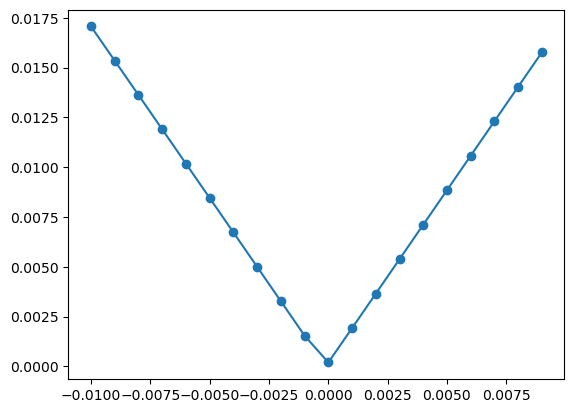

In [29]:
plt.figure()
plt.plot(r, [abs(f.sum()) for f in fun], ls='-', marker='o')

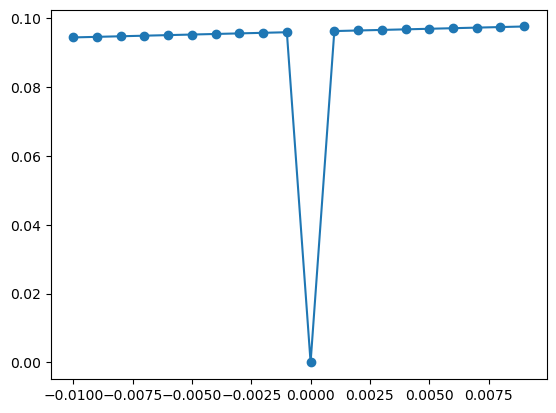

In [30]:
plt.figure()
plt.plot(r,[abs(j[0,0,0][0]) for j in jac], ls='-', marker='o')

In [31]:
C = np.array([0.0041, 0.000, 0.0000])
r = jnp.linalg.norm(C)

In [32]:
jnp.arctan2(C[2], C[1]), jnp.arctan2(C[2], C[1]+EPS)

(Array(0., dtype=float64), Array(0., dtype=float64))

In [33]:
from matplotlib import pyplot as plt

In [34]:
from matplotlib import pyplot as plt

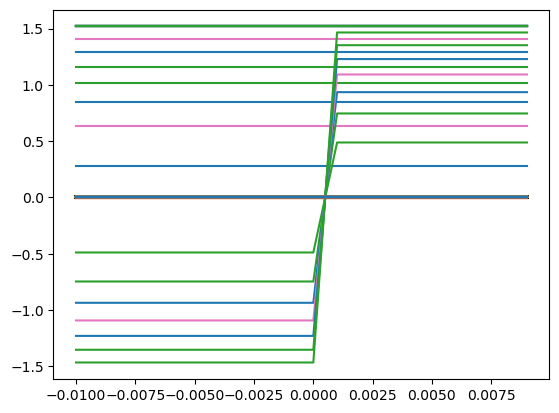

In [35]:
arr = jnp.arange(-0.01, 0.01, 0.001)
res = []
for z in arr:
    res.append(HARMONY(jnp.array([z, 0.000, 0.0]), 14).real)
plt.plot(arr, res)


In [36]:
HARMONY(jnp.array([0, 0.000, 0.0]), 14)

Array([ 0.28209479+0.j,  0.        +0.j,  0.48860251+0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.63078313+0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.74635267+0.j,  0.        +0.j,  0.        +0.j, -0.        +0.j,
        0.        -0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.84628438+0.j,  0.        +0.j,  0.        +0.j, -0.        +0.j,
       -0.        +0.j,  0.        -0.j,  0.        -0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.93560258+0.j,  0.        +0.j,
        0.        +0.j, -0.        +0.j, -0.        +0.j, -0.        -0.j,
       -0.        +0.j,  0.        -0.j,  0.        -0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  1.01710724+0.j,  0.        +0.j,
        0.        +0.j, -0.        +0.j, -0.        +0.j, -0.        -0.j,
       -0.        -0.j, -0.        +0.j, -0.        +0.j,  0.        -0.j,
        0.        -0.j,  

In [37]:
def theta(c):
    return jnp.arccos(_divide_zero_safe(c[0], jnp.linalg.norm(c), 1.0)-EPS*jnp.sign(c[0]))

In [38]:
def theta(c):
    return jnp.arccos((c[0]+EPS*jnp.sign(c[0]))/(jnp.linalg.norm(c)+EPS)-EPS*jnp.sign(c[0]))

In [40]:
from src.lib_math import _divide_zero_safe
jax.grad(_divide_zero_safe)(0.1, 0.1, 1.0), _divide_zero_safe(0.1, 0.1, 1.0)

(Array(10., dtype=float64, weak_type=True),
 Array(1., dtype=float64, weak_type=True))

In [ ]:
arr = jnp.linspace(-0.001+EPS, 0.001-EPS, 3000)

In [ ]:
f1 = lambda x: theta(jnp.array([x, 0.000, 0.]))
f2 = lambda x: jax.grad(theta)(jnp.array([x, 0.000, 0.]))

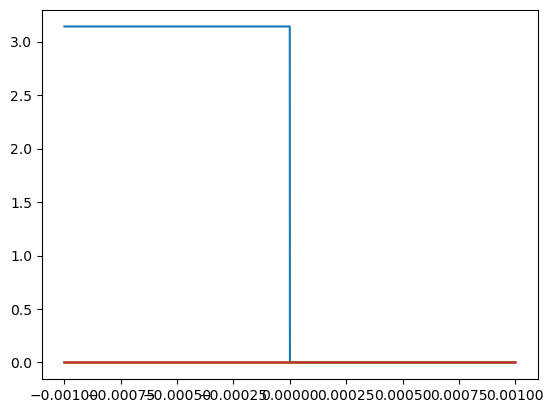

In [ ]:
plt.figure()
plt.cla()
plt.plot(arr, [f1(a) for a in arr])
plt.plot(arr, jax.vmap(f2)(arr))

In [ ]:
x = 1e-10
jax.jit(f1).lower(x).cost_analysis()['flops'], jax.jit(f2).lower(x).cost_analysis()['flops']

(19.0, 40.0)

In [ ]:
jax.vmap(f2)(arr)

Array([[-8.16496586e-05,  0.00000000e+00,  0.00000000e+00],
       [-8.17404898e-05,  0.00000000e+00,  0.00000000e+00],
       [-8.18314793e-05,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 9.09494702e-13,  0.00000000e+00,  0.00000000e+00],
       [-9.09494702e-13,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],      dtype=float64)

In [ ]:
f3 = jnp.arctan2
f4 = jax.grad(f4)

NameError: name 'f4' is not defined

In [ ]:
plt.figure()
plt.plot(arr, f3(arr,arr))
#plt.plot(arr, jax.vmap(f4)(arr))

In [ ]:
# Bessel
bessel(1e-20+1e-20j, 10)

Array([ 5.00000000e-01-5.00000000e-001j, -5.00000000e+19+0.00000000e+000j,
       -1.00000000e-01-1.00000000e-001j,  0.00000000e+00-2.85714286e-022j,
        3.17460317e-43-3.17460317e-043j,  5.77200577e-64-5.92000592e-106j,
        0.00000000e+00+0.00000000e+000j,  0.00000000e+00+0.00000000e+000j,
                   nan            +nanj,             nan            +nanj],      dtype=complex128)

In [41]:
config.update("jax_debug_nans", False)
print(bessel(0,10))
config.update("jax_debug_nans", True)

[ 1. nan nan nan nan nan nan nan nan nan]


In [ ]:
config.update("jax_debug_nans", False)